# Multimodal Pipeline for RAG

## Phase 0: Setting up the Project

In [44]:
!brew install poppler tesseract libmagic
%pip install "unstructured[pdf, md]" pillow pdf2image

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
sacad

You have 14 outdated formulae and 1 outdated cask installed.

To reinstall 25.04.0, run:
  brew reinstall poppler
To reinstall 5.5.0_1, run:
  brew reinstall tesseract
To reinstall 5.46, run:
  brew reinstall libmagic
Note: you may need to restart the kernel to use updated packages.


In [ ]:

#os.environ["UNSTRUCTURED_HI_RES_MODEL_NAME"] = "tesseract"
# only for ocr mode
os.environ["OCR_AGENT"] = "unstructured.partition.utils.ocr_models.tesseract_ocr.OCRAgentTesseract"

## Phase 1: Indexing

Indexing starts with the cleaning and extraction of raw data in diverse formats like PDF, HTML, Word, and Markdown, which is then converted into a uniform plain text format.

In [9]:
import os
file_path = "./assets/MTS2916A.pdf"

### Extraction

#### 1. Approach: Unstructered partition_pdf() Function
-> Tables where not extracted correctly

In [ ]:
from unstructured.partition.pdf import partition_pdf

chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,
    strategy="hi_res",                      # 'hi_res' or 'ocr_only'
    #hi_res_model_name='detectron2_onnx',   # 'yolox' has problems identifying tables! other options are 'detectron2_onnx'
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,   # If True, will extract base64 for API usage
    
    chunking_strategy='by_title',          # splitting strategy for the document (related elements are now grouped together) other options are 'basic'or 'by_title,
    max_characters=50000,                  # defaults to 500
    max_partition=None,
    #combine_text_under_n_chars=2000,       # defaults to 0
    #new_after_n_chars=6000,
    )

With the recent updates to the unstructured library (especially >=0.11.x), when using chunking_strategy="by_title", the output elements are wrapped as CompositeElement, grouping together content under headings — which can include Table, Text, Image, etc.

🔍 When to Use Raw Access (No Chunking)

✅ Use this when:
	•	Your primary goal is to extract specific elements, like tables, without worrying about their surrounding context.
	•	You want to classify, transform, or analyze tables or text independently.
	•	You’re building a pipeline where you process each element individually (e.g., sending them to LLMs, storing in a vector DB, etc.).

✅ Pros:
	•	Simple and straightforward.
	•	Full visibility into all content types.
	•	Easier debugging and testing.

❌ Cons:
	•	No semantic grouping — loses the logical structure (e.g., which section the table belongs to).

🧩 When to Use Chunking (e.g. by_title)

✅ Use this when:
	•	You want to preserve the document’s logical structure — e.g., sections, headings, context.
	•	You’re building a retrieval system, summarizer, or LLM pipeline that benefits from cohesive, meaningful chunks.
	•	You want to preserve the relationship between paragraphs and tables/images under a specific section.

✅ Pros:
	•	More semantically meaningful.
	•	Better input for language models.
	•	Maintains context between related elements.

❌ Cons:
	•	More complex to work with — requires digging into CompositeElement.elements.
	•	Slightly harder to extract just tables.

“Basic” chunking strategy: This method allows you to combine sequential elements to maximally fill each chunk while respecting the maximum chunk size limit. If a single isolated element exceeds the hard-max, it will be divided into two or more chunks.

“By title” chunking strategy: This strategy leverages the document element types identified during partitioning to understand the document structure, and preserves section boundaries. This means that a single chunk will never contain text that occurred in two different sections, ensuring that topics remain self-contained for enhanced retrieval precision. 

#### 2. Approach: Unstructured partition_image()
-> OCR Approach didn't deliver any better results

In [2]:
from pdf2image import convert_from_path
from unstructured.partition.image import partition_image
from PIL import Image
import pytesseract

images = convert_from_path(file_path, dpi=750)

/Users/maxtyrchan/Developer/DesignSpecs-RAG/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
chunks = []

for image in images:
    image.save("page.jpg", "JPEG")
    image = Image.open("page.jpg")
   
    element = partition_image(
        filename="page.jpg",
        strategy="hi_res",
        infer_table_structure=True,
    )

    chunks.append(element)

In [4]:
chunks

[[<unstructured.documents.elements.Image at 0x36128c1a0>,

In [ ]:
#pdf_elements is a list full of chunks. the different elements are stored in the metadata attribute of each chunk so next we have to extract the elements from the metadata with a loop

#pdf_elements[0].metadata.orig_elements


#### 3. Approach: Mistral OCR API
-> Using Mistral OCR API for document processing and text extraction delivered the best results.

In [7]:
%pip install mistralai

Note: you may need to restart the kernel to use updated packages.


In [11]:
from mistralai import Mistral
from pathlib import Path
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

api_key = os.environ.get("MISTRAL_API_KEY")
client = Mistral(api_key=api_key)

pdf_file = file_path

# Upload PDF file to Mistral's OCR service
uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file,
        "content": open(pdf_file, "rb"),
    },
    purpose="ocr",
)

# Get URL for the uploaded file
signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

# Process PDF with OCR, including embedded images
pdf_response = client.ocr.process(
    document=DocumentURLChunk(document_url=signed_url.url),
    model="mistral-ocr-latest",
    include_image_base64=True
)

# Convert response to JSON format
response_dict = json.loads(pdf_response.model_dump_json())

{'pages': [{'index': 0,
   'markdown': '# Dual Full-Bridge Motor Driver \n\n## Features\n\n- 750 mA Continuous Output Current\n- Load Voltage Supply: 10V to 40V\n- Full Bipolar Stepper Motor Drive Capability\n- Bidirectional DC Motor Capability\n- Internal Fixed T $_{\\text {OFF }}$ Time PWM Current Control\n- Internal Protection Diodes\n- Internal Thermal Shutdown\n- Under Voltage Lockout\n- LS-TTL Compatible Logic Inputs with Pull-Up Resistors\n- Low $\\mathrm{R}_{\\mathrm{ON}}$ Output Resistance\n- Low Quiescent Current\n- Operating Temperature Range: $-40^{\\circ} \\mathrm{C}$ to $+105^{\\circ} \\mathrm{C}$\n- Pin Compatible with Allegro 2916\n\n\n## Applications\n\n- Stepper Motor Actuators\n- DC Motor Actuators\n- Automotive HVAC Ventilation\n- Automotive Power Seats\n\nNote: The MTS2916A device is formerly a product of Advanced Silicon.\n\n## Description\n\nThe MTS2916A motor driver is a CMOS device capable of driving both windings of a bipolar stepper motor or bidirectionally c
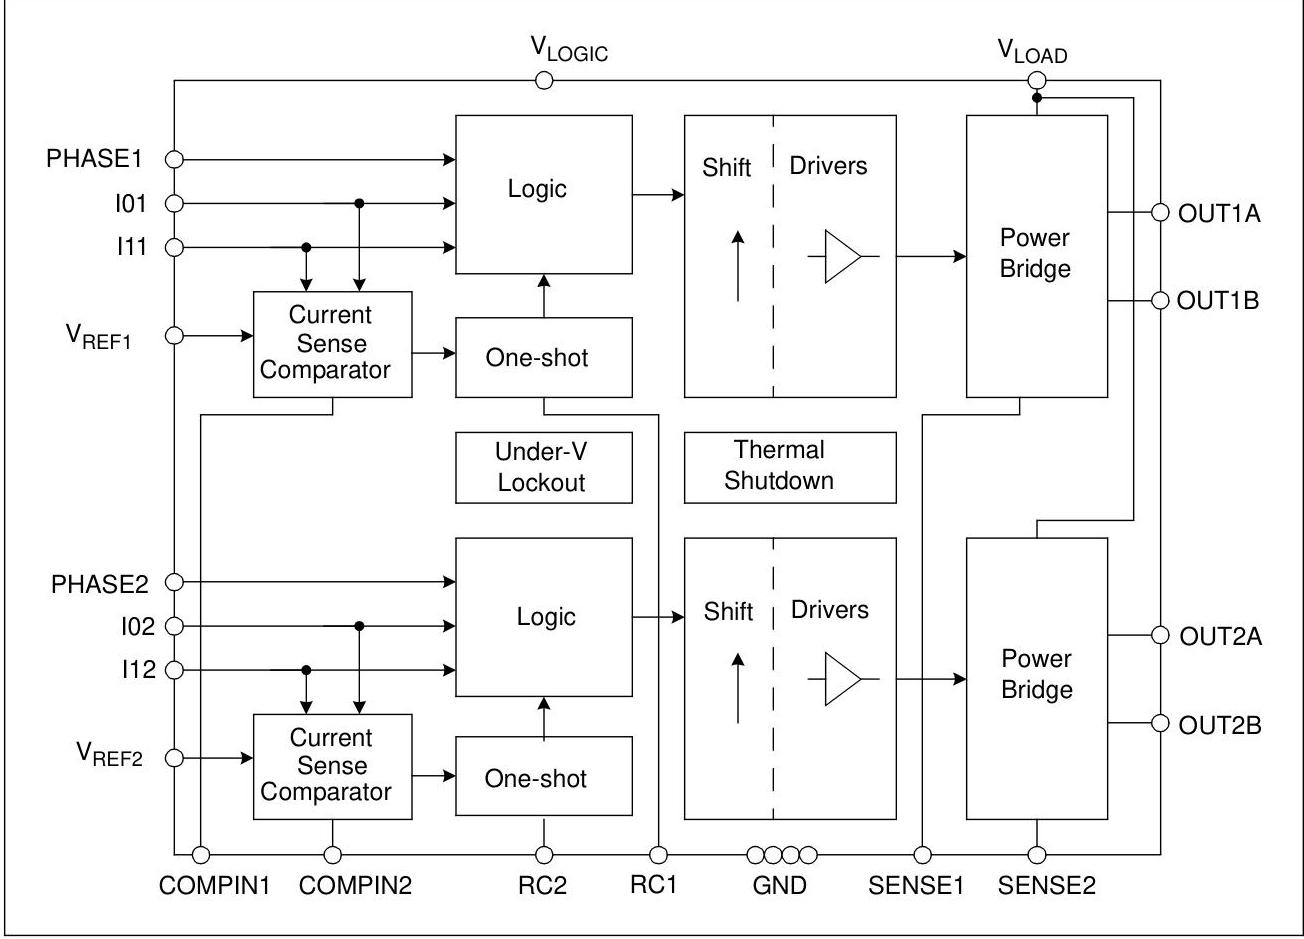
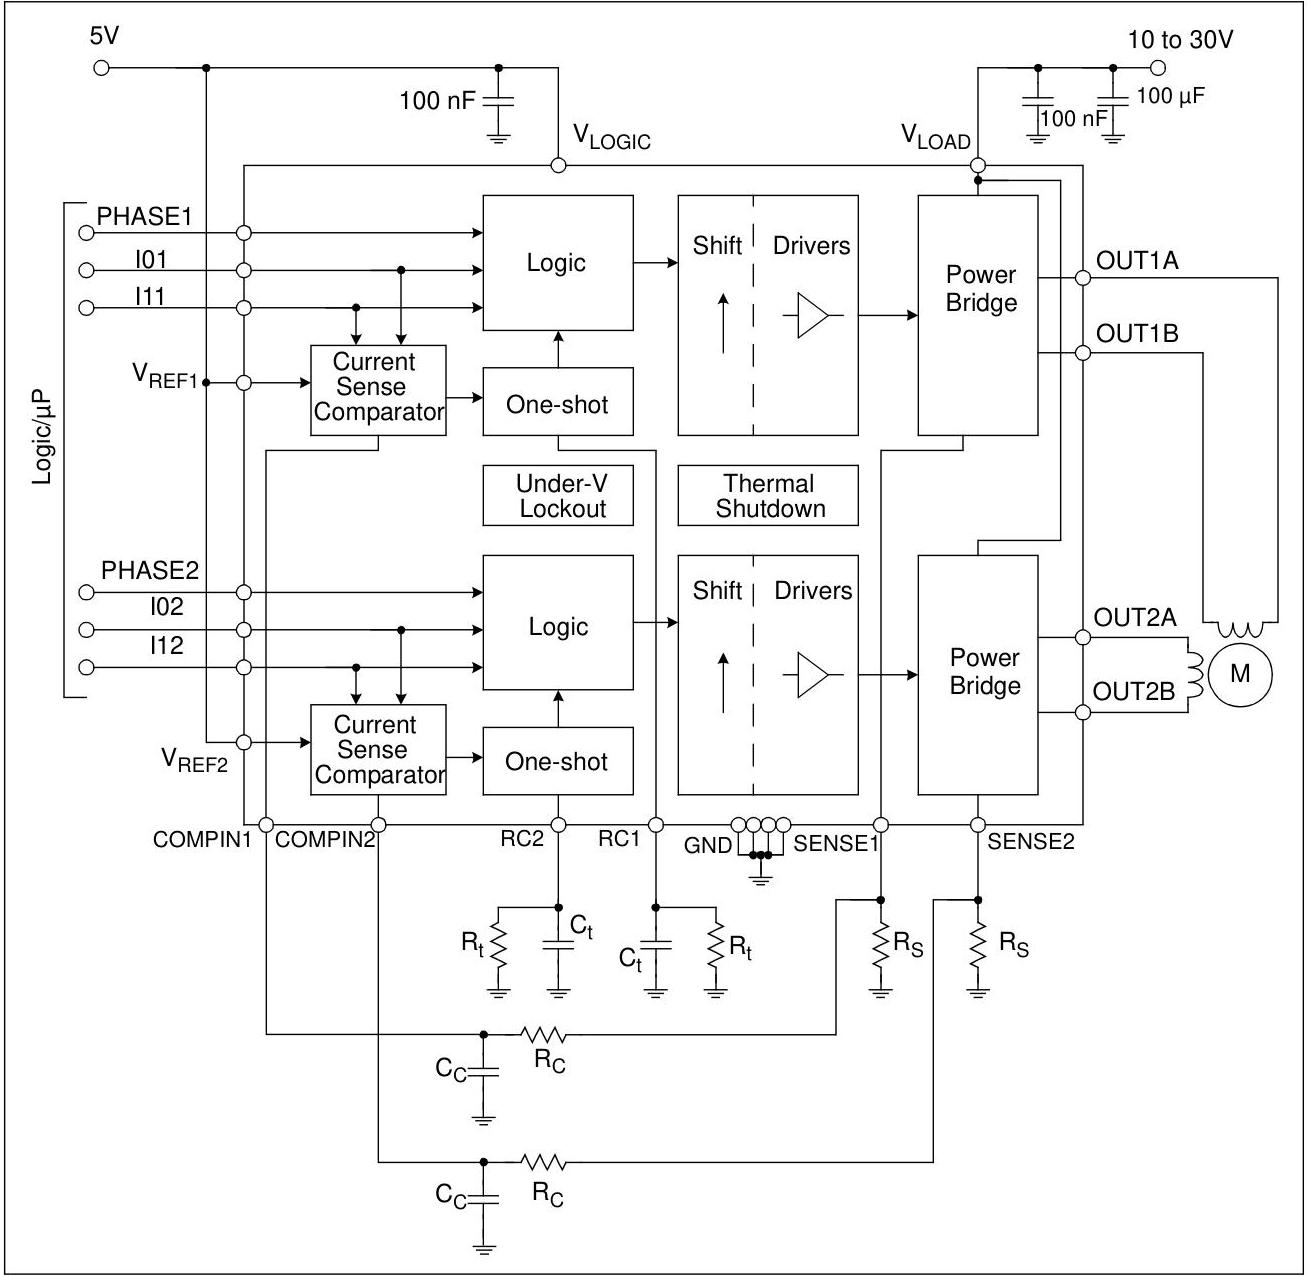
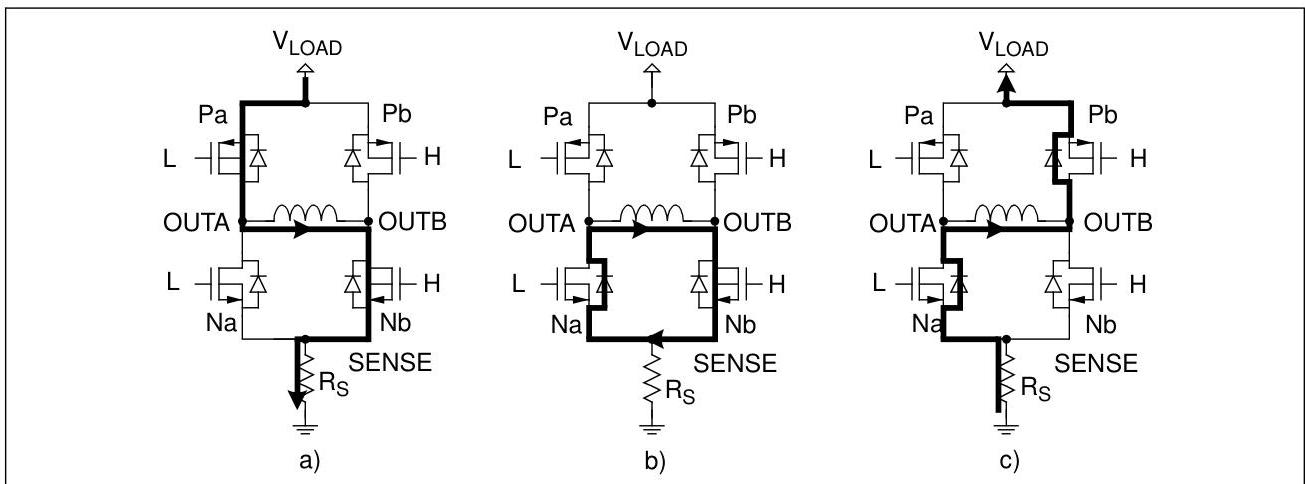
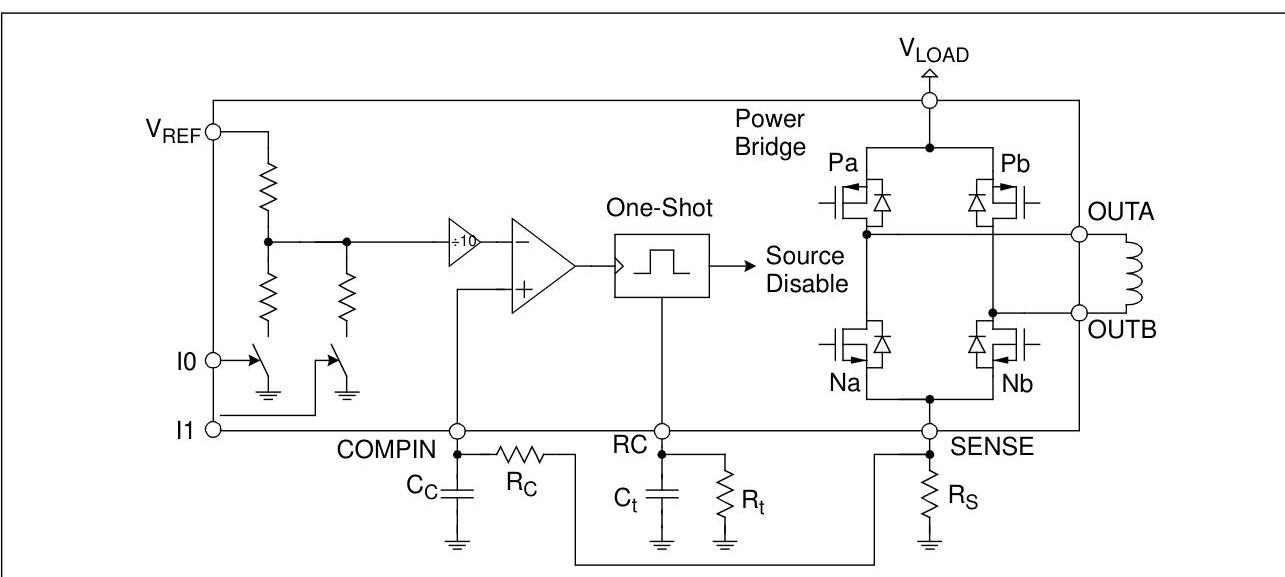
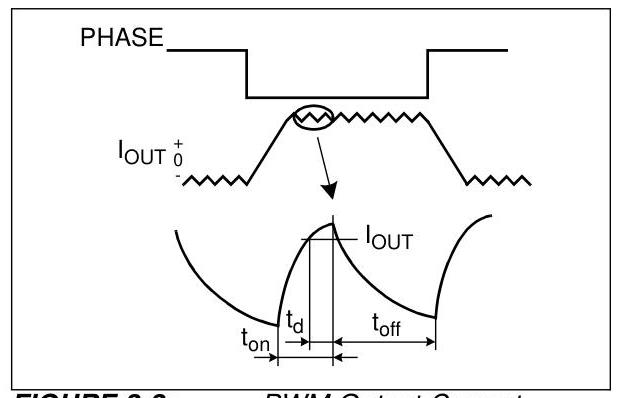
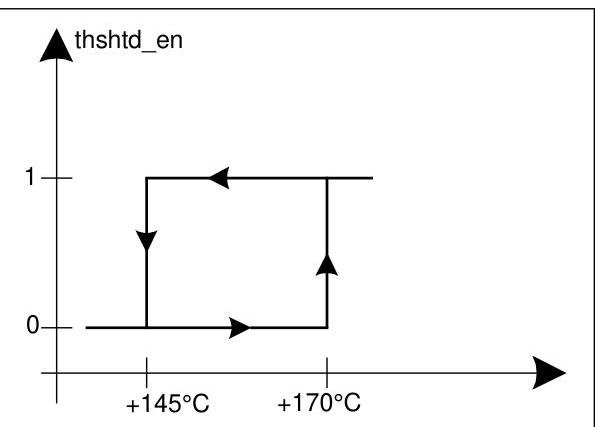
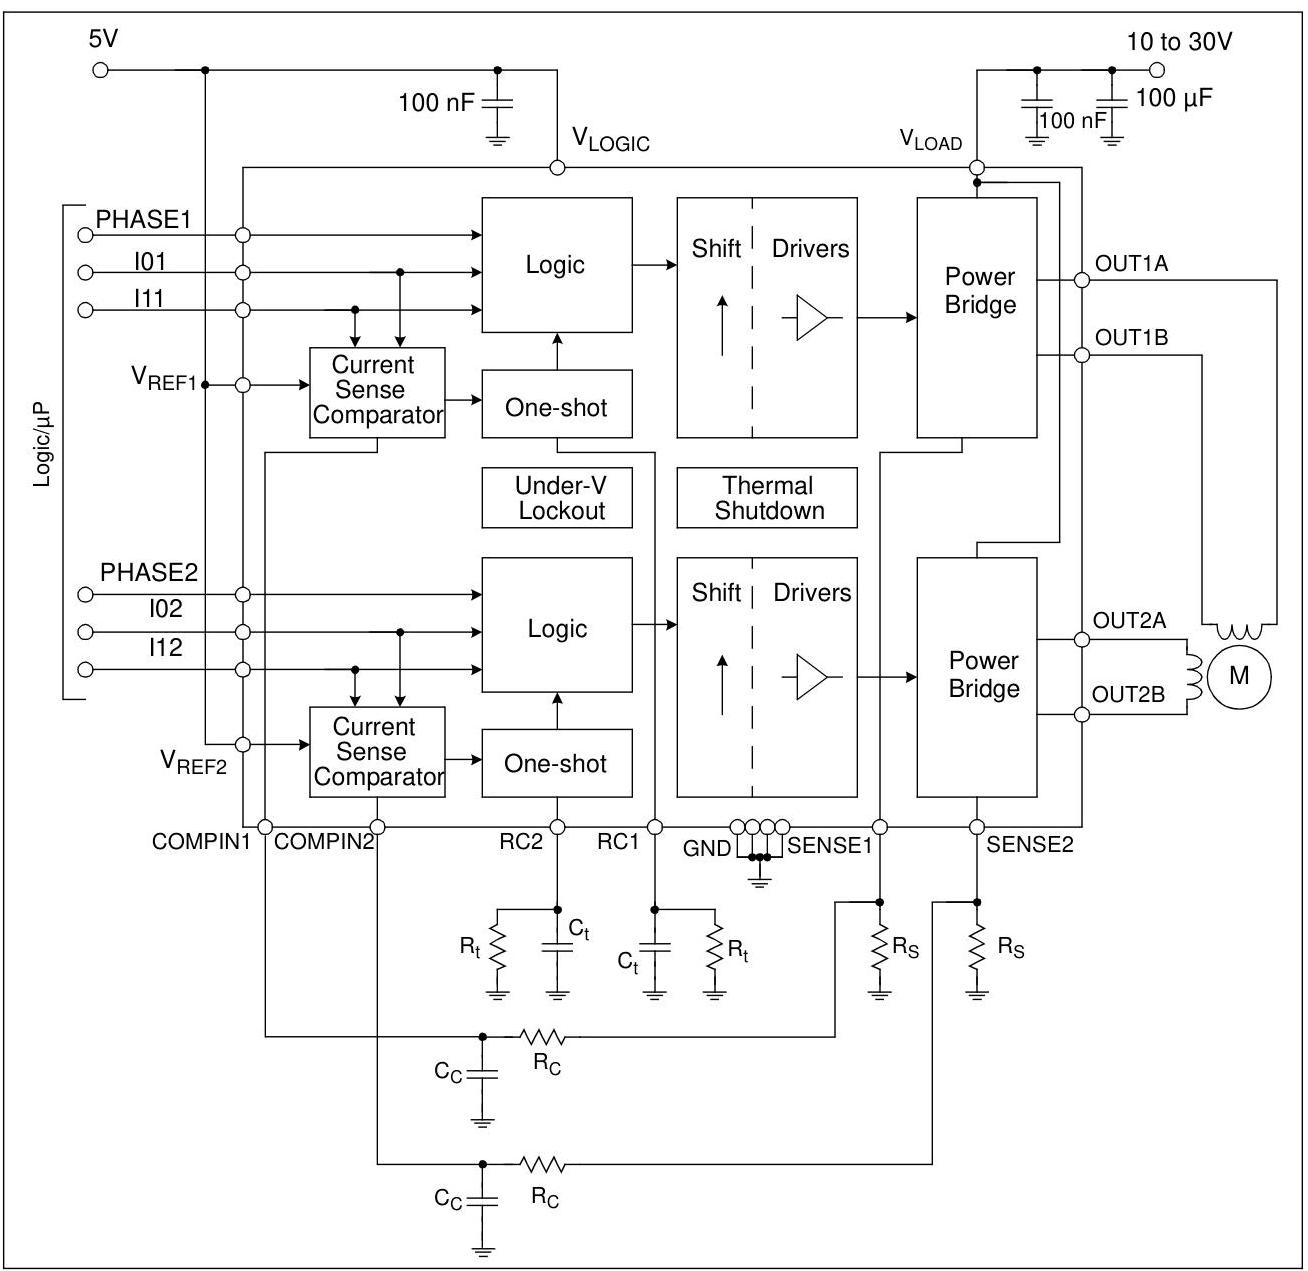
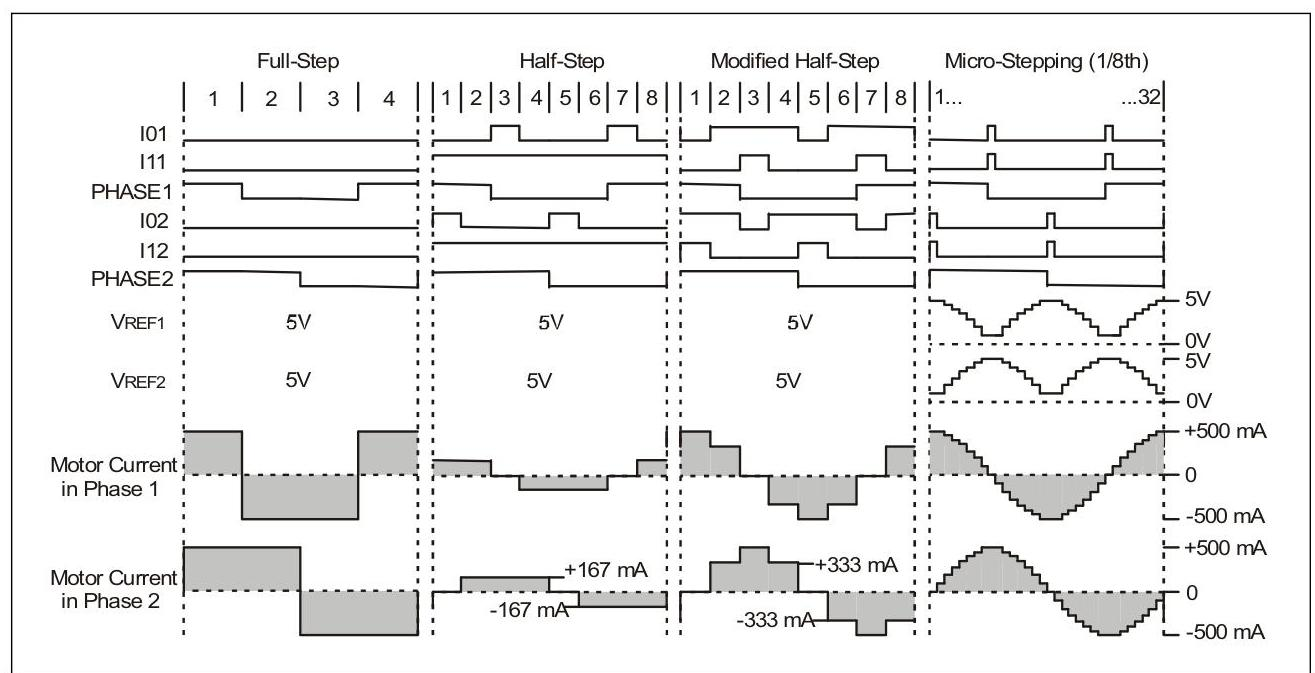
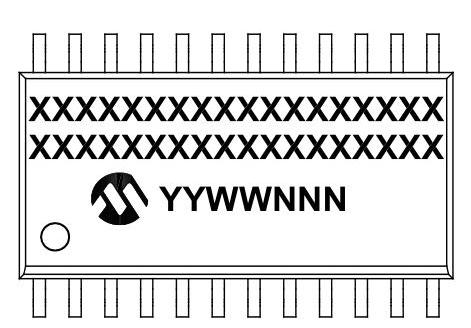
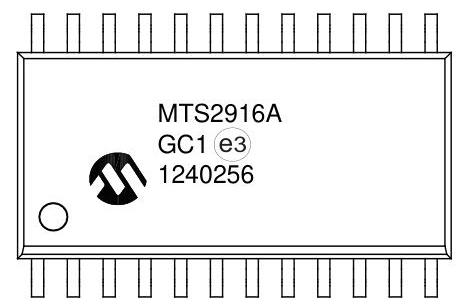
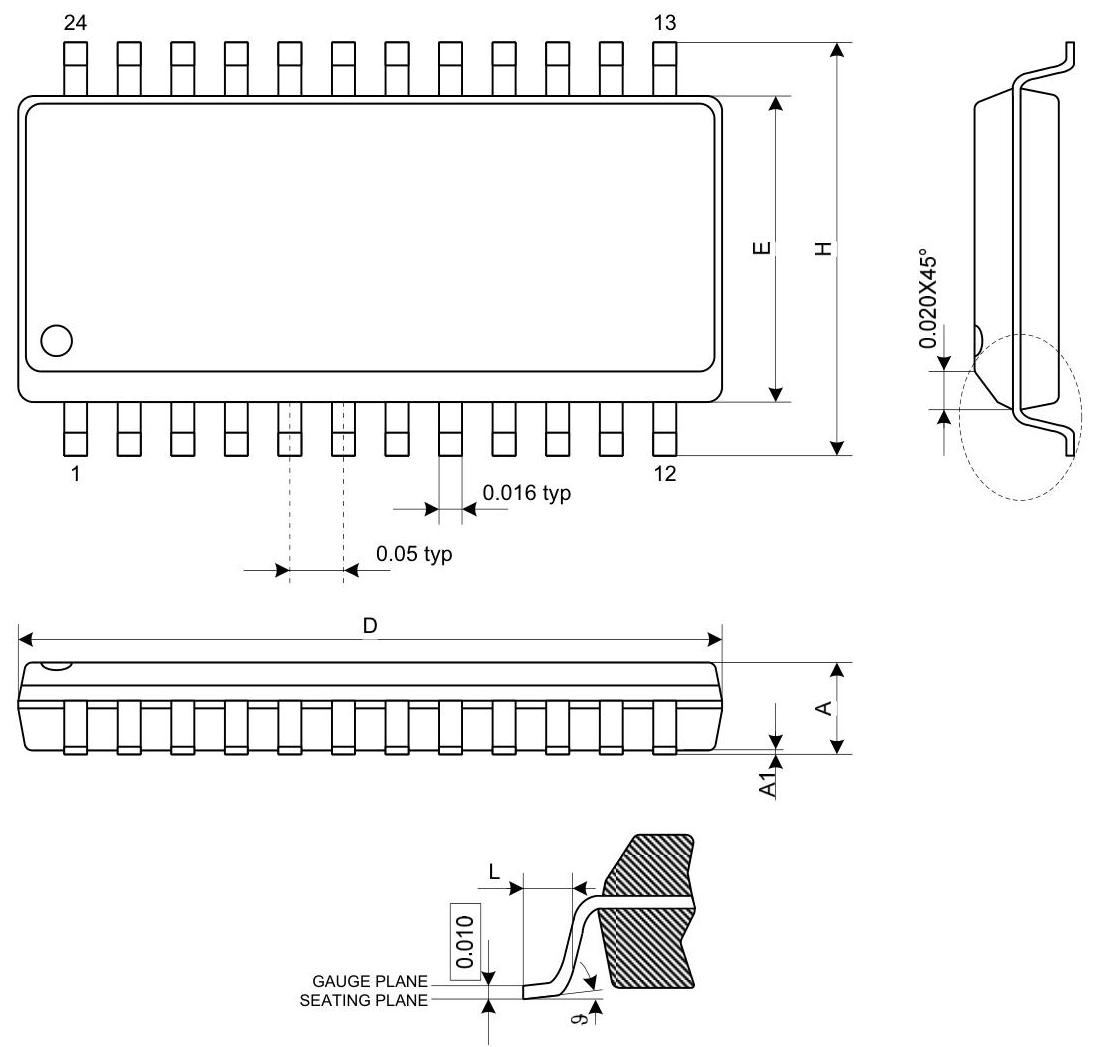
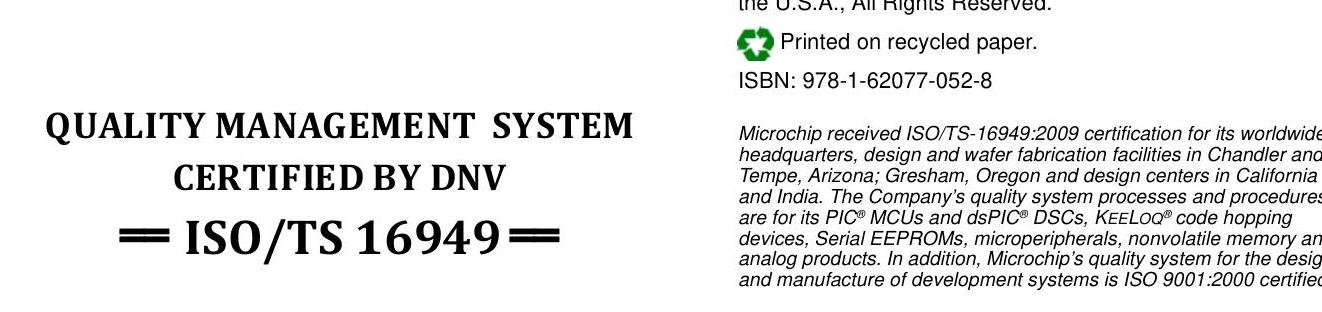

In [12]:
response_dict

Separate markdown and images into lists

In [36]:
markdown = []
images = []

for page in response_dict["pages"]:
    markdown.append(page["markdown"])
    if page["images"] is not None:
        for image in page["images"]:
            images.append(image["image_base64"])

Try to partition the markdown into text and tables with unstructured

In [45]:
from unstructured.partition.md import partition_md

file_path = "test.md"

chunks = partition_md(
    filename=file_path,
)

In [46]:
chunks

In [49]:
tables = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)
        chunks.remove(chunk)

In [56]:
print(tables[1].text)

Parameters Sym Min Typ Max Units Conditions DC Characteristics Logic Supply Voltage $\mathrm{V}_{\text {LOGIC }}$ 4.5 5.0 5.5 V Load Supply Voltage $\mathrm{V}_{\text {LOAD }}$ 10 30 40 V Logic Supply Current $\mathrm{I}_{\text {VLOGIC }}$ - 0.8 1.0 mA $\mathrm{V}_{\text {REF }}$ Voltage Range $\mathrm{V}_{\text {REF }}$ 1.5 5.0 7.0 V Driver Supply Current $\mathrm{I}_{\text {VLOAD_ON }}$ - 0.55 1.0 mA Both Bridges ON, No Load $\mathrm{I}_{\text {VLOAD } _ \text {OFF }}$ - 0.55 1.0 mA Both Bridges OFF Control Logic Input Current $\left(\mathrm{V}_{\mathrm{IN}}=0 \mathrm{~V}\right.$ ) $\mathrm{I}_{\mathrm{IN}}$ - - $-70$ $\mu \mathrm{A}$ $\begin{aligned} & \text { I01, I11 ,I02, I12, PHASE1, } \ & \text { PHASE2 (Note 1) } \end{aligned}$ Logic-Low Input Voltage $\mathrm{V}_{\mathrm{IL}}$ - - 0.8 V $\begin{aligned} & \text { I01, I11, I02, I12, PHASE1, } \ & \text { PHASE2 } \end{aligned}$ Logic-High Input Voltage $\mathrm{V}_{\mathrm{IH}}$ 2.4 - - V $\begin{aligned} & \text { I01, I11, 

##### Test Function to recreate the pdf and check the results

In [37]:
with open('test.md', 'w') as f:
        for text in markdown:
            f.write(text)

In [30]:
import base64

def data_uri_to_bytes(data_uri):
    _, encoded = data_uri.split(',', 1)
    return base64.b64decode(encoded)

def export_image(image):
    parsed_image = data_uri_to_bytes(image["image_base64"])
    with open(image["id"], 'wb') as file:
        file.write(parsed_image)

with open('output.md', 'w') as f: 
    for page in response_dict["pages"]:
        f.write(page["markdown"])
        for image in page["images"]:
            export_image(image)

### For Approach 1-2: Separate extracted elements into tables, text and images

#### Separate tables from texts

In [ ]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "CompositeElement" in str(type(chunk)):
        for el in chunk.metadata.orig_elements:
            if "Table" in str(type(el)):
                tables.append(el)
                #remove table from chunk
                chunk.metadata.orig_elements.remove(el)

In [6]:
tables_html = [table.metadata.text_as_html for table in tables]
tables_html[1]

'<table><thead><tr><th rowspan="2"></th><th colspan="2" rowspan="2">VLocic C)</th><th colspan="2" rowspan="2">Ti T 100 UF 100 nF VLOAD = = C)</th></tr></thead><tbody><tr><td>PHASE1 O oO _!01</td><td></td><td></td><td>Power (|</td><td>dOQUTIA</td></tr><tr><td colspan="5">Bridge | 41</td></tr><tr><td></td><td></td><td></td><td></td><td>C)</td></tr><tr><td></td><td></td><td></td><td>Power Bridge</td><td>OUT2A C) OUT2B</td></tr><tr><td>a</td><td>a Current</td><td></td><td></td><td>C)</td></tr><tr><td>V O</td><td>Sense COMPIN27</td><td>_</td><td>O)</td><td></td></tr><tr><td colspan="5">SENSE2 COMPIN1</td></tr></tbody></table>'

In [ ]:
# For Testing only!
# Search for Table in chunk
for chunk in chunks:
    if "Table" in str(type(chunk)):
        print("Found Table in chunk")
        print(chunk.metadata.orig_elements)
        #print(chunk.metadata

#### Get the images from the CompositeElement objects

In [ ]:
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
                    chunk.metadata.orig_elements.remove(el)
    return images_b64

images = get_images_base64(chunks)

In [ ]:
#Check if images are still in the chunks
for chunk in chunks:
    if "Image" in str(type(chunk)):
        print("Found Image in chunk")
        print(chunk.metadata.orig_elements)
        #print(chunk.metadata.orig_elements

#### The rest is text

In [ ]:
# The rest of the chunks are text
texts = []
for chunk in chunks:
    texts.append(chunk)

In [ ]:
#print(texts[0])

## Phase 2: Summarization

In [ ]:
%pip install --upgrade --quiet  langchain-openai
%pip install dotenv

In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os
from dotenv import load_dotenv
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.5,
    check_every_n_seconds=1,
    max_bucket_size=500000,
)
load_dotenv()
azure_api_key = os.environ.get("AZURE_OPENAI_API_KEY")
azure_endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT")

### Summarization of Tables

In [ ]:
# Prompt
prompt_text ="""
You are a helpful assistant tasked with summarizing tables precisely.
Give a concise summary of the table.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)
#rate_limiter=rate_limiter,

# Summary chain
model = AzureChatOpenAI(
    azure_deployment="gpt-4o",
    azure_endpoint=azure_endpoint,
    openai_api_key=azure_api_key,
    api_version="2024-12-01-preview",
    temperature=1.0,
    model="gpt-4o"
)
#summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()
summarize_chain = prompt | model | StrOutputParser()

In [ ]:
tables_html = [table.metadata.text_as_html for table in tables]
tables_html[1]

In [ ]:

#table_summaries = summarize_chain.invoke(tables_html)
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [ ]:
print(table_summaries[2])

In [ ]:
from lxml import etree

def validate_html_tables(table_list):
    """
    Given a list of HTML snippets (strings) each containing a <table> element,
    returns a list of dicts with validation results.
    """
    results = []
    for idx, html in enumerate(table_list, start=1):
        parser = etree.HTMLParser()  # collects parse errors
        try:
            # Try to parse the snippet
            etree.fromstring(html, parser)
            errors = parser.error_log
            valid = len(errors) == 0
        except etree.XMLSyntaxError as e:
            # Fatal syntax error
            valid = False
            errors = [e]
        
        # Record result
        results.append({
            'table_index': idx,
            'valid': valid,
            'errors': [str(err) for err in errors]
        })
    return results

In [ ]:
for res in validate_html_tables(tables_html):
        print(f"Table #{res['table_index']}:",
              "Valid" if res['valid'] else "INVALID")
        if not res['valid']:
            print("  Errors:")
            for err in res['errors']:
                print("   -", err)

In [ ]:
tables_html[26]

### Summarization of Images

In [ ]:
prompt_template = """You are a helpful assistant tasked with describing a image in detail. For context, the image is part of a design specification explaining the design of a digital temperature sensor.
Respond only with the description, no additional comment. Do not start your message by saying "Here is a description" or anything like that. Just give the description as it is."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | model | StrOutputParser()

image_summaries = chain.batch(images)

## Phase 3: Vectorization

### Create Vectorstore

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="DesignSpecsRAG", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

### Load Data

In [ ]:
# Add texts
retriever.vectorstore.add_texts(texts)

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

## Phase 4: Retrieval

In [ ]:
# Retrieve
docs = retriever.invoke(
    "What is MTS2916A?"
)

for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)